In [4]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import random
import random_seed

In [5]:
# Apply random seed to all randomness
random_seed.make_random(42)

In [50]:
transform = transforms.Compose([    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
                                ])
    
load_data = torchvision.datasets.CIFAR10(root = './data', train = False, download= False, transform=transform)
loader = DataLoader(load_data, batch_size=10000, num_workers=4, shuffle=False)

In [260]:
print(type(load_data))

<class 'torchvision.datasets.cifar.CIFAR10'>


In [218]:
def plot_image(src, label) :
    label_map = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    #src = src*(0.5) + 0.5
    src_np = src.numpy()
    src_np = np.transpose(src_np, (1, 2, 0))
    plt.imshow(src_np)
    plt.title(label_map[int(label)])

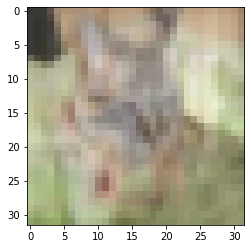

In [95]:
src_ratio = 0.7

# Denormalizing
src_tr, sample_tr = np.transpose(src, (1, 2, 0)), np.transpose(sample, (1, 2, 0))
src_denorm = (src_tr*0.5)+0.5
sample_denorm = (sample_tr*0.5)+0.5

mixup = src_denorm*src_ratio + sample_denorm*(1-src_ratio)
plt.imshow(mixup)

In [221]:
def mixup_dataset(origin_dataset, recon_ratio, src_ratio, mixup_class) :
    # mixup_class : tuple data which means what class is mixed up
    loader = DataLoader(origin_dataset, batch_size = len(origin_dataset), shuffle = False, num_workers = 4)
    # treat all dataset, make no batch and set shuffle False because we put randomness later
    # we consider origin_dataset is Tensor type data, balanced dataset and we mixup images by one-to-one following indices
    image, label = iter(loader).next()
    image = (image * 0.5) + 0.5
    search_idx = []


    for mixup in mixup_class :
        src_class, noise_class = mixup[0], mixup[1]
        # get src, noise indices in dataset
        src_idx = (label==src_class).nonzero().view(-1)
        noise_idx = (label==noise_class).nonzero().view(-1)

        n_src = src_idx.size()[0]
        n_noise = noise_idx.size()[0]
        n_mixup = int(n_src*recon_ratio)
        # n_src 중에서 recon_ratio 만큼의 indices를 random하게 extract
        src_apply_idx = torch.LongTensor(np.random.choice(n_src, n_mixup))
        noise_apply_idx = torch.LongTensor(np.random.choice(n_noise, n_mixup))

        # extract mixup indices by randomly, 실제 mixup이 적용되는 idx
        src_selected = src_idx[src_apply_idx]
        noise_selected = noise_idx[noise_apply_idx]

        # extract source, noise image
        src_image = image[src_selected]
        noise_image = image[noise_selected]

        # make mixup image and replace source class's original image
        mixup_image = (src_image*src_ratio) + (noise_image*(1-src_ratio))

        search_idx.append(src_selected)        

        for index, replace_idx in enumerate(src_selected) :
            image[replace_idx] = mixup_image[index]

    return image, label, search_idx

In [248]:
mixup_image, mixup_label, mixup_idx = mixup_dataset(load_data, 0.2, 0.7, ((2, 4), (3, 5)))
print('image :', mixup_image.shape)
print('label :', mixup_label.shape)

image : torch.Size([10000, 3, 32, 32])
label : torch.Size([10000])


In [249]:
mixup_idx[1].shape

torch.Size([200])

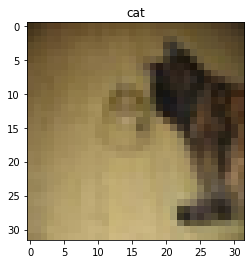

In [250]:
index = 323
plot_image(mixup_image[index], mixup_label[index])

In [237]:
def show_multiple_images(image, label) :
    label_map = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    fig = plt.figure(figsize = (10, 4))
    for i in range(10) :
        np_img = image[i].numpy()
        np_img = np.transpose(np_img, (1, 2, 0))
        ax = fig.add_subplot(2, 5, i+1)
        ax.imshow(np_img)
        ax.set_title(label_map[int(label[i])])
        ax.axis('off')

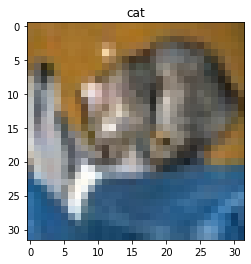

In [251]:
plot_image(mixup_image[0], mixup_label[0])

In [255]:
X = mixup_image
X = (X-0.5)/0.5
y = mixup_label

mixup_data = torch.utils.data.TensorDataset(X, y)

In [256]:
len(mixup_data)

10000

In [257]:
print(type(X))
print(type(y))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [258]:
mixup_data

In [259]:
mixup_loader = DataLoader(mixup_dataset, batch_size = 50, shuffle = True, num_workers = 4)

TypeError: object of type 'function' has no len()